In [4]:
# %load "../ml-mangrove/Segmentation/unet.py"
import torch
import segmentation_models_pytorch as smp
#import keras
#import tensorflow as tf
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import argparse
import rasterio
import subprocess
#import tensorflow_datasets as tfds
from PIL import Image
#from segmentation_models.utils import set_trainable
from glob import glob
from datetime import datetime
from PIL import Image
from tqdm import tqdm

In [8]:
#importing notebooks
#from ipynb.fs.full.<notebook_name> import *
from ipynb.fs.full.create_seg_dataset import create_seg_dataset
from ipynb.fs.full.gen_seg_labels import gen_seg_labels, tif_to_jpg, tile_raster
from ipynb.fs.full.raster_mask import raster_mask

In [6]:
# Resources: https://yann-leguilly.gitlab.io/post/2019-12-14-tensorflow-tfdata-segmentation/

'''
Documentation/Usage: This script is meant to be called with command line arguments.
--width (required): tile width
--input_rasters (required): space separated list of rasters (orthomosaics)
--input_vectors (required for training): space separated list of shapefiles (ordering should correspond with rasters)
--train: Flag. Add if training.
--test: Flag. Add if testing.
--weights (required): path to weights file, either to write to for training, or to use for testing (.h5)
--backbone (required): name of backbone to use, ex: resnet34, vgg16

For training it should be sufficient to just call the script using the list of rasters and vectors (and other required arguments), 
and currently you have to manually set the hyperparams in the code, but this should eventually be offloaded to a settings file or 
command line arguments. This will result in the training weights being saved in the specified .h5 file.

For testing you just need to call the script on the list of rasters and it will produce a mask of the entire
orthomosaic.
'''
#keras.backend.set_image_data_format('channels_first')
sm.set_framework('tf.keras')    # need this otherwise currently a bug in model.fit when used with tf.Datasets

# Globals
N_CHANNELS = 3
WIDTH = 256
HEIGHT = 256
LOSS_FUNC = sm.losses.DiceLoss()
NUM_CLASSES = 2

In [9]:
def parse_image(img_path: str) -> dict:
    """Load an image and its annotation (mask) and returning
    a dictionary.

    Parameters
    ----------
    img_path : str
        Image (not the mask) location.

    Returns
    -------
    dict
        Dictionary mapping an image and its annotation.
    """
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    # Creating mask path from image path
    mask_path = tf.strings.regex_replace(img_path, "images", "annotations")
    mask_path = tf.strings.regex_replace(mask_path, "image", "annotation")
    mask = tf.io.read_file(mask_path)

    # The masks contain a class index for each pixels
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.image.convert_image_dtype(mask, tf.uint8)
    
    #mask = tf.where(mask == 255, np.dtype('uint8').type(0), mask)
    # Note that we have to convert the new value (0)
    # With the same dtype than the tensor itself
    

    return {'image': image, 'segmentation_mask': mask}

In [8]:
@tf.function
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    """Rescale the pixel values of the images/masks between 0.0 and 1.0
    compared to [0,255] originally.

    Parameters
    ----------
    input_image : tf.Tensor
        Tensorflow tensor containing an image of size [SIZE,SIZE,3].
    input_mask : tf.Tensor
        Tensorflow tensor containing an annotation of size [SIZE,SIZE,1].

    Returns
    -------
    tuple
        Normalized image and its annotation.
    """
    input_mask = tf.cast(input_mask, tf.float32) / 255.0 # attempting to fix metrics
    #input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

In [9]:
@tf.function
def load_image_train(datapoint: dict) -> tuple:
    """Apply some transformations to an input dictionary
    containing a train image and its annotation.

    Notes
    -----
    An annotation is a regular  channel image.
    If a transformation such as rotation is applied to the image,
    the same transformation has to be applied on the annotation also.

    Parameters
    ----------
    datapoint : dict
        A dict containing an image and its annotation.

    Returns
    -------
    tuple
        A modified image and its annotation.
    """
   
    input_image = tf.image.resize(datapoint['image'], (HEIGHT, WIDTH))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (HEIGHT, WIDTH))
    #input_mask = tf.image.rgb_to_grayscale(datapoint['segmentation_mask'])
    
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    
    #input_mask = tf.reshape(input_mask, (HEIGHT, WIDTH))  # removing single channel

    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

In [10]:
@tf.function
def load_image_val(datapoint: dict) -> tuple:
    """Normalize and resize a test image and its annotation.

    Notes
    -----
    Since this is for the val set, we don't need to apply
    any data augmentation technique.

    Parameters
    ----------
    datapoint : dict
        A dict containing an image and its annotation.

    Returns
    -------
    tuple
        A modified image and its annotation.
    """
    input_image = tf.image.resize(datapoint['image'], (HEIGHT, WIDTH))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (HEIGHT, WIDTH))
    
    input_image, input_mask = normalize(input_image, input_mask)
    #input_mask = tf.reshape(input_mask, (HEIGHT, WIDTH)) # removing single channel

    
    return input_image, input_mask

In [11]:
@tf.function
def load_image(datapoint: dict) -> tuple:
    """Loads and image and resizes it

    Parameters
    ----------
    datapoint : dict
        A dict containing an image and its annotation.

    Returns
    -------
    tuple
        A image and its annotation.
    """
    input_image = tf.image.resize(datapoint['image'], (HEIGHT, WIDTH))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (HEIGHT, WIDTH))
    #input_mask = tf.image.resize(datapoint['label'], (HEIGHT, WIDTH))

    return input_image, input_mask

In [12]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [13]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    #return pred_mask[0]
    return pred_mask

In [14]:
def show_predictions(model=None, dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask[0])])

In [15]:
def train(backbone, weight_file):
    # For tensorboard
    #logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    #tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir, update_freq='epoch')


    # For more information about autotune:
    # https://www.tensorflow.org/guide/data_performance#prefetching
    #AUTOTUNE = tf.data.experimental.AUTOTUNE
    #print(f"Tensorflow ver. {tf.__version__}")

    # For reproducibility
    SEED = 42

    # Data
    training_data = "../dataset/training/"
    #val_data = "../dataset/validation/"

    # Listing GPU info
    #gpus = tf.config.experimental.list_physical_devices('GPU')
    #if gpus:
    #    try:
     #       for gpu in gpus:
      #          tf.config.experimental.set_memory_growth(gpu, True)
       #     logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        #print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        #except RuntimeError as e:
         #   print(e)

    # Hyperparams
    BATCH_SIZE = 16
    BUFFER_SIZE = 1000 # See https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle

    # Creating and splitting dataset
    DATASET_SIZE = len(glob(training_data + "images/*.jpg"))
    print(f"The Training Dataset contains {DATASET_SIZE} images.")

    TRAIN_SIZE = int(0.8 * DATASET_SIZE)
    VAL_SIZE = int(0.2 * DATASET_SIZE)

    
    
    full_dataset = tf.data.Dataset.list_files(training_data + "images/*.jpg", seed=SEED)
    full_dataset = full_dataset.shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
    train_dataset = full_dataset.take(TRAIN_SIZE)
    val_dataset = full_dataset.skip(TRAIN_SIZE)
    
    # Creating dict pairs linking images and annotations
    train_dataset = train_dataset.map(parse_image)
    val_dataset = val_dataset.map(parse_image)

    # -- Train Dataset --# - https://stackoverflow.com/questions/49915925/output-differences-when-changing-order-of-batch-shuffle-and-repeat
    train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    train_dataset = train_dataset.shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
    train_dataset = train_dataset.repeat()
    train_dataset = train_dataset.batch(BATCH_SIZE)
    train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

    #-- Validation Dataset --#
    #for image, label in tfds.as_numpy(val_dataset):
     # print(type(image), type(label), label)
    
    val_dataset = val_dataset.map(load_image_val, num_parallel_calls=AUTOTUNE)
    val_dataset = val_dataset.repeat()
    val_dataset = val_dataset.batch(BATCH_SIZE)
    val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

    
    # define model
    model = sm.Unet(
        #'resnet34',
        #'vgg16', 
        backbone,
        input_shape=(HEIGHT, WIDTH, N_CHANNELS), 
        encoder_weights='imagenet', 
        encoder_freeze=True,    # only training decoder network
        classes=NUM_CLASSES,
        activation='sigmoid'
    )
    
    model.compile(
        'Adam', 
        loss=LOSS_FUNC, 
        metrics=[sm.metrics.iou_score] #was giving score over 100 in later epochs before normalizing masks
        #[tf.keras.metrics.MeanIoU(num_classes=2)]]
    )
    # TODO research step sizes
    history = model.fit(
    train_dataset,
    epochs=50,
    steps_per_epoch=TRAIN_SIZE / BATCH_SIZE,
    validation_data=val_dataset,
    validation_steps= 0.2 * (VAL_SIZE / BATCH_SIZE),
    callbacks=[tensorboard_callback]
    )

    # Saving model
    #model.save_weights("unet_500_weights_vgg16.h5")
    model.save_weights(weight_file)

    # For reinstantiation
    #model = keras.models.load_model(your_file_path)

In [16]:
# function to display slice of batch in datasets, as images

%matplotlib inline
from matplotlib import pyplot as plt

def showDataImgs(train_dataset, val_dataset, n):
    train_dataset_np = tfds.as_numpy(train_dataset)
    val_dataset_np = tfds.as_numpy(val_dataset)
    

    example = next(val_dataset_np)
    image = example[0]
    label = example[1]
    
    print("val_label: ", label.shape)#label[11])
    print("val_image: ", image.shape)
    
    label_slice = label[n].reshape(HEIGHT,WIDTH)
    plt.imshow(label_slice, cmap='gray')
    plt.show()
    plt.imshow(image[n])
    plt.show()

    print(label[n])

    
    example = next(train_dataset_np)
    image = example[0]
    label = example[1]
    
    print("train_label: ",label.shape)#label[15])
    print("train_image: ",image.shape)
    
    label_slice = label[n].reshape(HEIGHT,WIDTH)
    plt.imshow(label_slice, cmap='gray')
    plt.show()
    plt.imshow(image[n])
    plt.show()
    
    print(label[n])

    #print(image[0])
    # label_grey = np.mean(label[n], -1)
    # label_grey.reshape((256,256, 1))

The Training Dataset contains 2985 images.
val_label:  (16, 256, 256, 1)
val_image:  (16, 256, 256, 3)


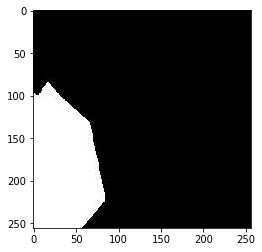

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


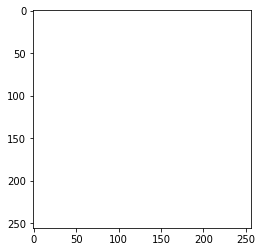

[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[1.]
  [1.]
  [1.]
  ...
  [0.]
  [0.]
  [0.]]

 [[1.]
  [1.]
  [1.]
  ...
  [0.]
  [0.]
  [0.]]

 [[1.]
  [1.]
  [1.]
  ...
  [0.]
  [0.]
  [0.]]]
train_label:  (16, 256, 256, 1)
train_image:  (16, 256, 256, 3)


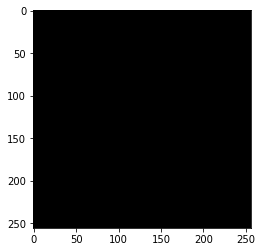

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


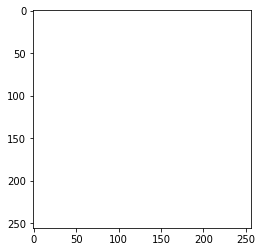

[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]


In [17]:
# use to view images/masks in dataset
AUTOTUNE = tf.data.experimental.AUTOTUNE
SEED = 42
training_data = "../dataset/training/"
BATCH_SIZE = 16
BUFFER_SIZE = 1000 # See https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle

# Creating and splitting dataset
DATASET_SIZE = len(glob(training_data + "images/*.jpg"))
print(f"The Training Dataset contains {DATASET_SIZE} images.")

TRAIN_SIZE = int(0.8 * DATASET_SIZE)
VAL_SIZE = int(0.2 * DATASET_SIZE)

full_dataset = tf.data.Dataset.list_files(training_data + "images/*.jpg", seed=SEED)
full_dataset = full_dataset.shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
train_dataset = full_dataset.take(TRAIN_SIZE)
val_dataset = full_dataset.skip(TRAIN_SIZE)
    
# Creating d1ict pairs linking images and annotations
train_dataset = train_dataset.map(parse_image)
val_dataset = val_dataset.map(parse_image)

# -- Train Dataset --# - https://stackoverflow.com/questions/49915925/output-differences-when-changing-order-of-batch-shuffle-and-repeat
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

#-- Validation Dataset --#
val_dataset = val_dataset.map(load_image_val, num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.repeat()
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)


showDataImgs(train_dataset, val_dataset, 4)


In [18]:
#for example in train_dataset.take(1):  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
#for example in next(val_dataset_np):
  #print(example)
  #image = example[0]
  #label = example[1]
  #label = tf.cast(label, tf.float32) / 255.0 #normalizing label  
  #print((image==label).all())
  #print(image.size)
#  image_img = Image.fromarray(image, 'RGB')
 #
  #plt.imshow(image)
  #plt.show()
#   image_img.save('image_test.png')
#   image_img.show()

#  label_img = Image.fromarray(label, 'RGB')
  #label= np.reshape(label, (256,256))
  #plt.imshow(label)
  #plt.show()
#   label_img.save('label_test.png')
#   label_img.show()

# for example in val_dataset.take(2):  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
#   #print(example)
#   #image = example[0]
#   #label = example[1]
#   print(image.shape, label.shape)

In [19]:
def test(backbone, weight_file):

    AUTOTUNE = tf.data.experimental.AUTOTUNE
    print(f"Tensorflow ver. {tf.__version__}")

    # For reproducibility
    SEED = 42

    # Relevant directories/files
    image_dir = "../dataset/testing/images"
    annotation_dir = "../dataset/testing/annotations"
    out_dir = "../dataset/testing/output"
    testing_data = "../dataset/testing/"
    model_weights = weight_file

    #Listing GPU info
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
       try:
           for gpu in gpus:
               tf.config.experimental.set_memory_growth(gpu, True)
           logical_gpus = tf.config.experimental.list_logical_devices('GPU')
           print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
       except RuntimeError as e:
           print(e)

    # Hyperparams
    BATCH_SIZE = 16
    BUFFER_SIZE = 1000 # See https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle

    model = sm.Unet(
        #'vgg16', 
        backbone,
        input_shape=(HEIGHT, WIDTH, N_CHANNELS), 
        encoder_weights='imagenet', 
        weights=model_weights,
        encoder_freeze=True,    # only training decoder network
        classes=NUM_CLASSES, 
        activation='sigmoid'
    )

    # Might be unnecessary
    model.compile(
        'Adam', 
        #loss=sm.losses.bce_jaccard_loss, 
        loss=LOSS_FUNC,
        metrics=[sm.metrics.iou_score]
    )

    test_dataset = glob(os.path.join(image_dir, "*.jpg"))
    
    # Loop for inference
    print("\nStarting inference... \n")
    for img_file in tqdm(test_dataset):
        tif_file = img_file.replace("jpg", "tif")

        img = np.asarray(Image.open(img_file)) #/ 255.0 # normalization not needed as we dont normalize the img for training
        img = img[np.newaxis, ...] # needs (batch_size, height, width, channels)
        pred_mask = model.predict(img)[0]
        pred_mask = create_mask(pred_mask)
        pred_mask = np.array(pred_mask).astype('uint8') * 255

        # Reading metadata from .tif
        with rasterio.open(tif_file) as src:
            tif_meta = src.meta
            tif_meta['count'] = 1

        # Writing prediction mask as a .tif using extracted metadata
        mask_file = tif_file.replace("images", "output")
        with rasterio.open(mask_file, "w", **tif_meta) as dest:
            # Rasterio needs [bands, width, height]
            pred_mask = np.rollaxis(pred_mask, axis=2)
            dest.write(pred_mask)
	#printing out metrics
	#results = model.evaluate(img, pred_mask, batch_size=128)
	#print("IOU: ", results) 
    print("Merging tiles (to create mask ortho)...")
    call = "gdal_merge.py -o " + testing_data + "ortho_mask.tif " + " " + out_dir + "/*"
    print(call)
    subprocess.call(call, shell=True)

In [20]:
def test_optimized(backbone, weight_file):
    '''
    Note: This version of test does not work yet. It is optimized to be very efficient and works well for inference on .jpg files.
    It lacks the capabilities to link the output predictions to the input .jpgs since the filenames are lost when in the tf.dataset
    we map the parse image function. As a result, we need to somehow modify this dataset to retain filename information so we can use it
    to link the output prediction to the input image and its corresponding .tif file, which will be used to write the geospatial info to
    the prediction.

    Initial ideas would be to modify the parse image function and related functions to save filename info, and use this to link the images
    in the prediction stage by replacing .jpg with .tif in the filename.
    '''
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    print(f"Tensorflow ver. {tf.__version__}")

    # For reproducibility
    SEED = 42

    # Relevant directories/files
    images = "../dataset/testing/images"
    annotations = "../dataset/testing/annotations"
    testing_data = "../dataset/testing/"
    #model_weights = "unet_500_weights_vgg16.h5"
    model_weights = weight_file

    # Listing GPU info
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            print(e)

    # Hyperparams
    BATCH_SIZE = 16
    BUFFER_SIZE = 1000 # See https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle

    model = sm.Unet(
        'resnet34', 
        input_shape=(HEIGHT, WIDTH, N_CHANNELS), 
        encoder_weights='imagenet', 
        weights=model_weights,
        encoder_freeze=True,    # only training decoder network
        classes=2, 
        activation='softmax'
    )

    # Might be unnecessary
    model.compile(
        'Adam', 
        loss=LOSS_FUNC, 
        metrics=[sm.metrics.iou_score]
    )

    test_dataset = tf.data.Dataset.list_files(testing_data + "images/*.jpg", seed=SEED)
    test_dataset = test_dataset.map(parse_image)
    test_dataset = test_dataset.map(load_image_val, num_parallel_calls=AUTOTUNE)
    test_dataset = test_dataset.batch(BATCH_SIZE)
    test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

    image_data = []
    annotation_data = []
    
    '''
    for img_file in tqdm(os.listdir(images)): 
        annotation_file = "annotation_" + img_file.split('_')[1]
        img_file = os.path.join(images, img_file)
        ann_file = os.path.join(annotations, annotation_file)
        image = np.array(Image.open(img_file))
        annotation = np.array(Image.open(ann_file))
        image_data.append(image)
        annotation_data.append(annotation)
    '''


    #prediction = model.predict(test_dataset, steps=1)
    #print(type(prediction))


    #display([first_image[0], first_mask[0], create_mask(first_pred_mask)])

    #pred_mask = model.predict(test_dataset)
    #display([image[0], mask[0], create_mask(pred_mask)])

    show_predictions(model=model, dataset=test_dataset, num=20)

In [21]:
def train_setup(raster_files, vector_files, out_width):
    # Uses raster and vector file to create dataset for training
    data_files = zip(raster_files, vector_files)
    map_files = [] 

    for raster_file, vector_file in data_files:
        # Generates raster masks
        print("Creating raster_masks...")
        raster_mask(raster_file, vector_file)
        temp_dir = os.path.dirname(vector_file)
        mask_file = os.path.join(temp_dir, "masks", "mask_binary.tif")

        # Generates segmentation labels
        out_dir = os.path.dirname(raster_file)
        gen_seg_labels(out_width, raster_file, vector_file, mask_file, out_dir, True, True)
        map_file = os.path.join(out_dir, "map.txt")
        map_files.append(map_file)

    # Creating dataset to train UNet
    create_seg_dataset(map_files, "training", 0)

In [22]:
def test_setup(raster_files, out_width):
    out_dir = "../dataset/testing/output"
    test_dir = "../dataset/testing"
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    print("\nTiling rasters...")
    for raster_file in raster_files:
        tile_raster(out_width, raster_file, test_dir, True, False)

In [ ]:
#initalize arguments
out_width = "256"
raster_files = ["../dataset/training/images/lap_2019-07_site03_120m_RGB_quick.tif"]#, "../dataset/training/images/lap_2019-07_site06_120m_RGB_quick.tif"]
vector_files = ["../dataset/training/vectors/lap_2019-07_site03_labels_m-nm.shp"]#, "../dataset/training/vectors/lap_2019-07_site06_labels_m-nm.shp"]
weight_file = "../dataset/training/weights/07_16_vgg16_50_03_weight.h5"
backbone = "vgg16"

In [ ]:
#Run Testing
test_setup(raster_files, out_width)
test(backbone, weight_file)

In [3]:
#Run Training
train_setup(raster_files, vector_files, out_width)
train(backbone, weight_file)

NameError: name 'train_setup' is not defined

In [1]:
#view downsmapled testing output ortho_mask.tif
# !sudo apt-get update
# !sudo apt-get install libgdal-dev -y
# !sudo apt-get install python-gdal -y
# !sudo apt-get install python-numpy python-scipy -y
# !pip install rasterio
# !pip install fiona
# !pip install geopandas
# !pip install -i https://test.pypi.org/simple/ gis-utils-pkg-dillhicks==0.0.1
from gis_utils import raster
from rasterio.plot import show

#img_10, meta1 = raster.load_image("../dataset/testing/ortho_mask_10_2.tif")
#img_1, meta10 = raster.load_image("../dataset/testing/ortho_mask_1_1.tif")

#downsampling images 
ds_factor = 1
#resampled_1, transform = raster.downsample_raster(img_1, ds_factor)
#resampled_10, transform = raster.downsample_raster(img_10, ds_factor)

img, meta = raster.load_image("../dataset/testing/ortho_mask.tif")
show(img)
#show(resampled_10)


KeyboardInterrupt: 

In [ ]:
# if __name__ == "__main__":
#     TRAIN = False
#     TEST = False

#     parser = argparse.ArgumentParser(description="UNet Training and Inference Script (Note: order of rasters and vectors must correspond to one another)")
#     parser.add_argument("--width",help = "Width of output tiles")
#     parser.add_argument("--input_rasters", nargs='*', help = "space separated input orthomosaic (.tif)")
#     parser.add_argument("--input_vectors", nargs='*', help = "space separated input labels (.shp)")
#     parser.add_argument("--train", action='store_true', help = "training UNet")
#     parser.add_argument("--test", action='store_true', help = "testing UNet")
#     parser.add_argument("--weights", help = "path to weight file, either to save or use (.h5)")
#     parser.add_argument("--backbone", help = "segmentation model backbone, ex: resnet34, vgg16, etc.")
#     args = parser.parse_args()

#     # Parsing arguments
#     if args.width:
#         out_width = args.width
#     else:
#         print("Need to specify width, exiting.")
#         exit()
#     if args.input_rasters:
#         raster_files = args.input_rasters
#     else:
#         # Always needs a raster
#         print("Need to specify raster file, exiting.")
#         exit()
#     if args.input_vectors:
#         vector_files = args.input_vectors
#     else:
#         # Requires vector labes for training, not inference
#         if args.train:
#             print("Need to specify input vector, exiting.")
#             exit()
#     if args.train and args.test:
#         print("Can't train and test at the same time... exiting.")
#         exit()
#     elif args.train:
#         TRAIN = True
#     elif args.test:
#         TEST = True
#     if args.weights:
#         weight_file = args.weights
#     else:
#         print("Need weight file, exiting.")
#         exit()
#     if args.backbone:
#         backbone = args.backbone
#     else:
#         print("Need to specify backbone, exiting.")
#         exit()

#     # Selecting mode
#     if TRAIN: 
#         train_setup(raster_files, vector_files, out_width)
#         train(backbone, weight_file)
#     if TEST:
#         test_setup(raster_files, out_width)
#         test(backbone, weight_file)
#         #test_optimized(backbone, weight_file)